# EnvErgo project
- [ResearchGate link](https://www.researchgate.net/project/Isokinetic-measurements-and-musculoskeletal-modelling-for-ergonomics)

# Anthropometry Analysis

In [1]:
# libraries
import envergo  # local functions (see mvc/ folder)
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="ticks")
% matplotlib inline

In [2]:
df = pd.read_excel('./data/Anthropo_MTL.xlsx').dropna()
# set participant pseudo as index
df.set_index('Subject', inplace=True)
# remove unwanted string in Laterality column
df['Laterality'].replace(regex=True, inplace=True, to_replace=r"'", value=r'')
# print head
df.tail()

,Location,Age,Laterality,Height (m),Weight (kg),IMC,PA (h/sem),Trunk_length,Arm_length,Forearm_length,Hand_length,Pelvis_width,Hand_width
Subject,,,,,,,,,,,,,
CHMI29011992,montreal,1992,R,1.710,87.00,29.75,0.5,0.440,0.265,0.23,0.185,0.190,0.0450
BEMI16091980,montreal,1980,L,1.730,87.00,29.06,2.0,0.570,0.280,0.27,0.210,0.185,0.0420
ANMA08101983,montreal,1983,L,1.700,76.00,26.30,1.0,0.490,0.300,0.23,0.170,0.075,0.0110
HAAL30041963,montreal,1963,R,1.708,73.65,25.19,5.0,0.425,0.300,0.24,0.177,0.080,0.0200
CAJU22031991,montreal,1991,R,1.790,96.00,29.96,2.5,0.510,0.330,0.27,0.170,0.115,0.0275


## 1. Normality tests
- We have 12 variables (one is not numeric [`Laterality`])
- Let's test the normality of these variables with various normality tests

In [68]:
scipy.stats.anderson(df['Hand_length'])

AndersonResult(statistic=0.37063169871272095, critical_values=array([ 0.524,  0.597,  0.717,  0.836,  0.994]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

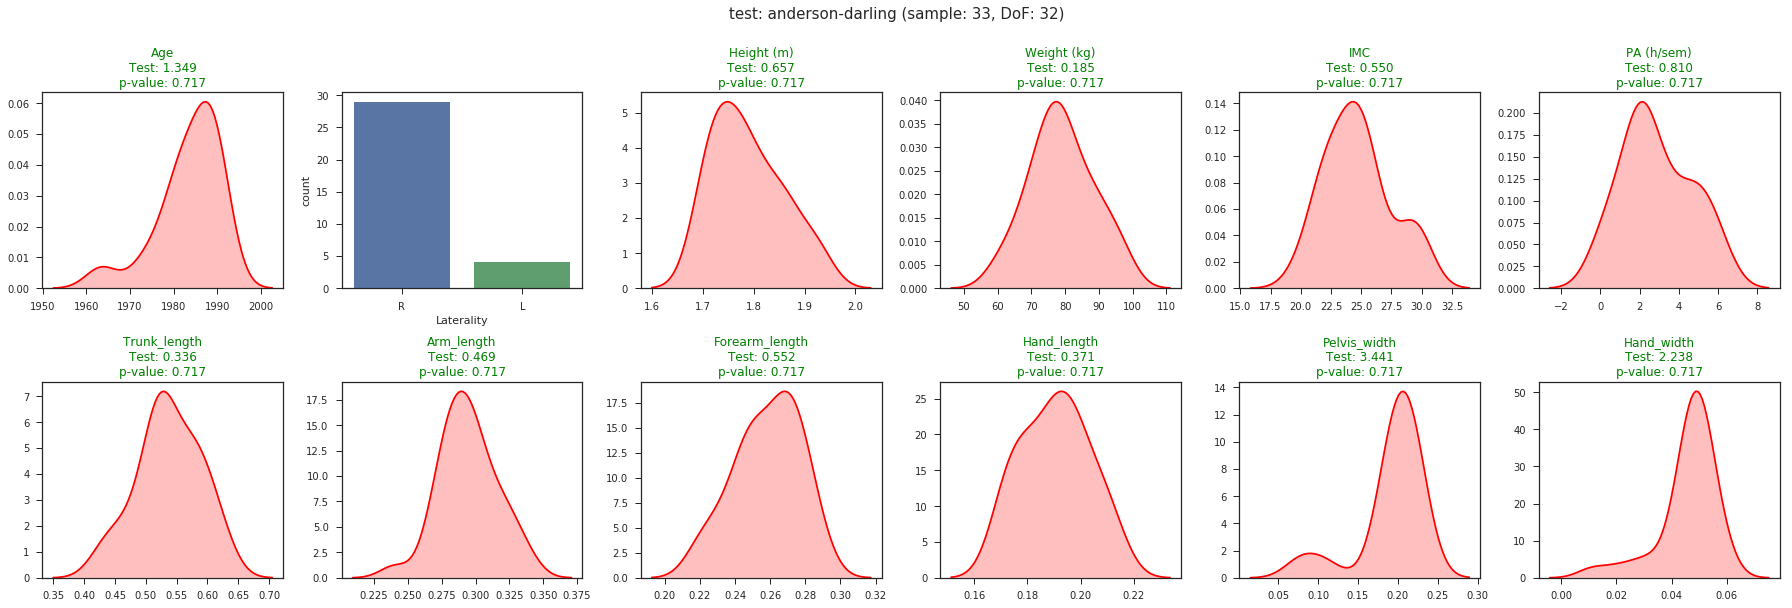

In [3]:
def normality_test(dataframe, kind='shapiro'):
    # various normality test functions
    normality_fct = {
        'shapiro': scipy.stats.shapiro,
        'anderson-darling': scipy.stats.anderson,
        'agostino-pearson': scipy.stats.mstats.normaltest
    }
    
    fig, axs = plt.subplots(2, 6, figsize=(25, 8))
    # get numeric columns
    numeric_col = df.dtypes[df.dtypes != "object"].index 
    
    for ivar, ax in zip(df.drop('Location', axis=1), axs.ravel()) :
        if ivar in numeric_col:
            # normality test
            test = normality_fct[kind](df[ivar])
            result = test[1][2] if kind == 'anderson-darling' else test[1]
            color = 'g' if result > 0.05 else 'r'
            ax.set_title('{}\nTest: {:.3f}\np-value: {:.3f}'.format(ivar, test[0], result), color=color)
            sns.kdeplot(df[ivar], shade=True, color="r", ax=ax)
            ax.legend_.remove()
        else:
            sns.countplot(x=ivar, data=df, ax=ax)
    fig.tight_layout()
    fig.suptitle('test: {} (sample: {}, DoF: {})'.format(kind, df[ivar].size, df[ivar].size - 1), y=1.05, fontsize=15)
    
normality_test(df, kind='anderson-darling')

### 1.1 Shapiro-Wilk
- The Shapiro-Wilk normality test is reputadely more well suited to smaller datasets.

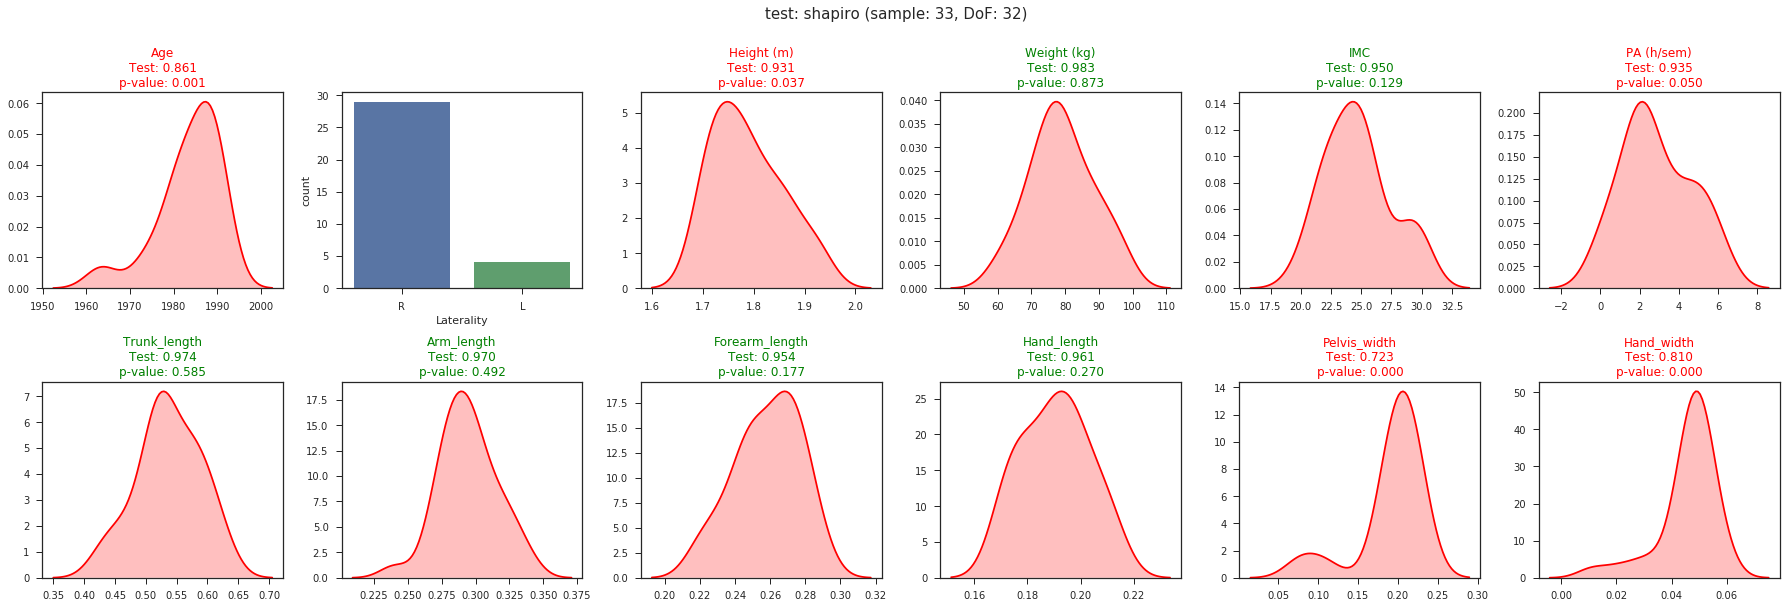

In [4]:
normality_test(df, kind='shapiro')

### 1.2 Anderson-Darling
- Anderson's test is derived from Kolmogorov test and is used in a similar way to test the null-hypothesis that data is sampled from a population that follows a particular distribution.

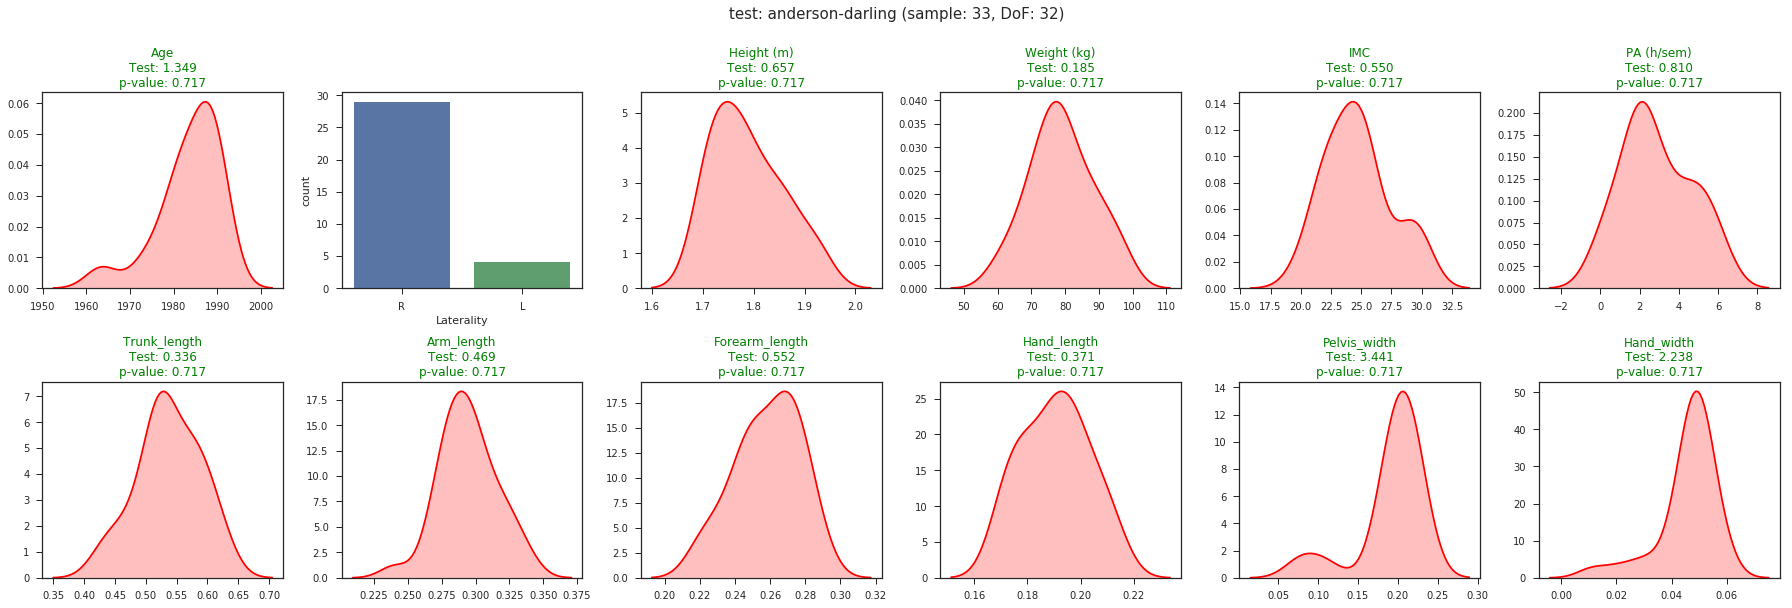

In [5]:
normality_test(df, kind='anderson-darling')

### 1.3 D’Agostino and Pearson
- We can combine the D'Agostino and Pearson method to generate a new test which considers the kurtosis, the sharpest point on the curve.

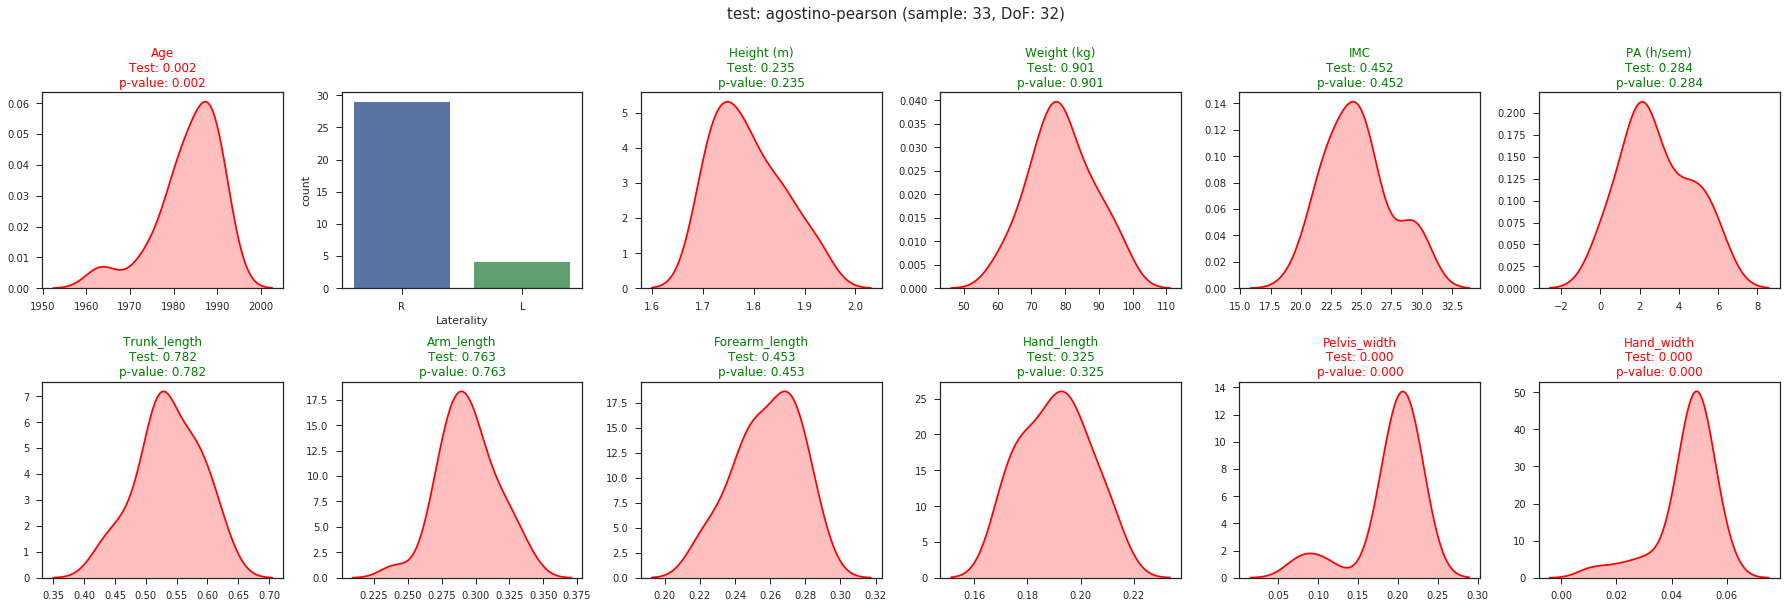

In [42]:
normality_test(df, kind='agostino-pearson')

## 2 Are the france-canada groups homogeneous?
scipy.stats.anderson_ksamp

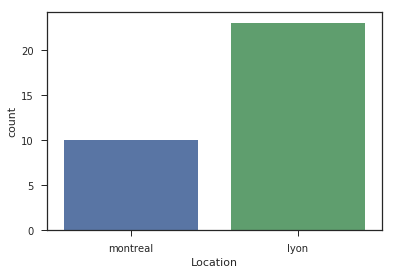

In [29]:
def normality_test(dataframe, kind='shapiro'):
    # various normality test functions
    normality_fct = {
        'shapiro': scipy.stats.shapiro,
        'anderson-darling': scipy.stats.anderson,
        'agostino-pearson': scipy.stats.mstats.normaltest
    }
    
    fig, axs = plt.subplots(2, 6, figsize=(25, 8))
    
    for ivar, ax in zip(df.drop('Location', axis=1), axs.ravel()) :
        if ivar in numeric_col:
            # normality test
            test = normality_fct[kind](df[ivar])
            if kind == 'anderson-darling':
                result = test[1][2]
            else:
                result = test[1]
            color = 'g' if result > 0.05 else 'r'
            ax.set_title('{}\nTest: {:.3f}\np-value: {:.3f}'.format(ivar, result, result), color=color)
            sns.kdeplot(df[ivar], shade=True, color="r", ax=ax)
            ax.legend_.remove()
        else:
            sns.countplot(x=ivar, data=df, ax=ax)
    fig.tight_layout()
    fig.suptitle('test: {} (sample: {}, DoF: {})'.format(kind, df[ivar].size, df[ivar].size - 1), y=1.05, fontsize=15)

## Outliers
- [link](https://plot.ly/python/outlier-test/)